<a href="https://colab.research.google.com/github/rsradhakrishnan/capstone-projects/blob/main/Chat_bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sun Oct 25 17:37:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
import keras
import tensorflow as tf
import nltk
import numpy
import sklearn
from keras.models import Model
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Input, Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from collections import Counter
import nltk
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
RAND_STATE=np.random.seed(42)
BATCH_SIZE = 256
NUM_EPOCHS = 10
GLOVE_EMBEDDING_SIZE = 100
HIDDEN_UNITS = 256
MAX_INPUT_SEQ_LENGTH = 40
MAX_TARGET_SEQ_LENGTH = 40
MAX_VOCAB_SIZE = 10000
DATA_SET_NAME = 'cornell'
DATA_PATH = '/gdrive/My Drive/Industry_Project /movie_lines_cleaned.txt'
GLOVE_MODEL = "/gdrive/My Drive/Industry_Project /glove.twitter.27B.100d.txt"
WHITELIST = 'abcdefghijklmnopqrstuvwxyz1234567890?.,'
WEIGHT_FILE_PATH =  DATA_SET_NAME + '-word-glove-weights.h5'

In [ ]:
def in_white_list(_word):
    for char in _word:
        if char in WHITELIST:
            return True
    return False

##Glove model


In [ ]:

def load_glove_vector():
    _word2embedding = {}
    file = open(GLOVE_MODEL, mode='rt', encoding='utf8')
    for line in file:
        words = line.strip().split()
        word = words[0]
        #embedding_vectors = np.asarray(words[1:])
        embedding_vectors = np.array(words[1:], dtype=np.float32)
        _word2embedding[word] = embedding_vectors
    file.close()
    return _word2embedding

In [ ]:
%%time
word2embed = load_glove_vector()

CPU times: user 28 s, sys: 894 ms, total: 28.9 s
Wall time: 28.9 s


In [ ]:
len(word2embed.keys())

1193514

In [ ]:
word2embed.get('train')

array([ 7.8224e-01,  2.1289e-01, -3.7750e-01, -1.0542e+00,  7.1538e-02,
        6.5285e-01, -5.0393e-02,  1.4292e-02, -3.3518e-01,  2.0516e-01,
       -5.7545e-02,  5.8780e-01, -3.4255e+00, -3.9355e-01, -1.9521e-01,
        1.6188e-01,  3.3833e-02, -2.4486e-01, -6.7231e-01, -3.0219e-01,
       -1.2911e-01, -1.0401e+00,  3.8679e-01, -5.5795e-01,  5.6450e-01,
       -4.3825e-01, -7.3374e-01,  5.0109e-01, -1.3601e-01,  1.4848e+00,
        1.1157e-01, -3.2571e-01, -7.0612e-01,  4.5017e-02,  5.7258e-01,
       -1.3414e-01, -1.3751e-01,  2.5518e-02,  1.1558e+00, -1.2307e-01,
        2.0635e-01,  1.1790e+00, -2.9565e-03, -5.6660e-01,  8.8233e-01,
       -2.0549e-01,  5.0556e-01, -2.8319e-01, -3.6040e-01, -4.7111e-01,
        3.1520e-01,  3.1712e-01, -1.4541e-01, -3.1394e-01, -6.7899e-01,
        8.6945e-02,  5.0997e-01,  5.0802e-01,  1.8457e-01,  1.1322e-01,
        7.1866e-01,  1.5100e-01,  2.5895e-01,  3.6208e-01, -6.0227e-01,
       -6.3969e-01, -1.3120e-01,  5.0847e-01, -2.6322e-01,  3.87

In [ ]:
word2embed.get('train').shape

(100,)

In [ ]:
#word2embed.get('judafbaidb').shape

In [ ]:
'''
assert len(word2embedding.keys())==1193513
for key in word2embedding.keys():
    try:
        assert len(word2embedding[key])==100
    except AssertionError:
        print (key,len(word2embedding[key]))     

'''

'\nassert len(word2embedding.keys())==1193513\nfor key in word2embedding.keys():\n    try:\n        assert len(word2embedding[key])==100\n    except AssertionError:\n        print (key,len(word2embedding[key]))     \n\n'

In [ ]:
target_counter = Counter()
lines = open(DATA_PATH, 'rt', encoding='utf8').read().split('\n')
input_texts = []
target_texts = []
prev_words = []

##Preprocessing

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
%%time
for line in lines:
    next_words = [w.lower() for w in nltk.word_tokenize(line)]
    if len(next_words) > MAX_TARGET_SEQ_LENGTH:
        next_words = next_words[0:MAX_TARGET_SEQ_LENGTH]
    if len(prev_words) > 0:
        input_texts.append(prev_words)
        target_words = next_words[:]
        target_words.insert(0, 'start')
        target_words.append('end')
        for w in target_words:
            target_counter[w] += 1
        target_texts.append(target_words)
    prev_words = next_words

CPU times: user 48.7 s, sys: 292 ms, total: 49 s
Wall time: 49 s


In [ ]:
#after Preprocessing
for idx, (input_words, target_words) in enumerate(zip(input_texts, target_texts)):
    if idx > 5:
        break
    print([input_words, target_words])

[['they', 'do', 'not', '!'], ['start', 'they', 'do', 'to', '!', 'end']]
[['they', 'do', 'to', '!'], ['start', 'i', 'hope', 'so', '.', 'end']]
[['i', 'hope', 'so', '.'], ['start', 'she', 'okay', '?', 'end']]
[['she', 'okay', '?'], ['start', 'let', "'s", 'go', '.', 'end']]
[['let', "'s", 'go', '.'], ['start', 'wow', 'end']]
[['wow'], ['start', 'okay', '--', 'you', "'re", 'gon', 'na', 'need', 'to', 'learn', 'how', 'to', 'lie', '.', 'end']]


## word2index and index2word dictionaries

In [ ]:
target_word2idx = dict()
'''create a target word to id dictionary called target_word2idx.
'''

for idx, word in enumerate(target_counter.most_common(MAX_VOCAB_SIZE)):
    target_word2idx[word[0]] = idx + 1

if 'unk' not in target_word2idx:
    target_word2idx['unk'] = 0

'''create a target to id dictionary called target_idx2word . '''

target_idx2word = dict([(idx, word) for word, idx in target_word2idx.items()])

num_decoder_tokens = len(target_idx2word)+1

np.save('word-glove-target-word2idx.npy', target_word2idx)
np.save('word-glove-target-idx2word.npy', target_idx2word)

In [ ]:
#assert len (target_word2idx.keys())==len (target_idx2word.keys())==MAX_VOCAB_SIZE+1

##creating dictionary of word embedding using loaded glove

In [ ]:
input_texts_word2em = []

encoder_max_seq_length = 0
decoder_max_seq_length = 0

for input_words, target_words in zip(input_texts, target_texts):
    encoder_input_wids = []
    for w in input_words:
        emb = np.zeros(shape=GLOVE_EMBEDDING_SIZE)
        if w in word2embed:
            emb = word2embed[w]
        encoder_input_wids.append(emb)

    input_texts_word2em.append(encoder_input_wids)
    encoder_max_seq_length = max(len(encoder_input_wids), encoder_max_seq_length)
    decoder_max_seq_length = max(len(target_words), decoder_max_seq_length)

context = dict()
context['num_decoder_tokens'] = num_decoder_tokens
context['encoder_max_seq_length'] = encoder_max_seq_length
context['decoder_max_seq_length'] = decoder_max_seq_length


np.save('word-glove-context.npy', context)

In [ ]:
print(context)

{'num_decoder_tokens': 10002, 'encoder_max_seq_length': 40, 'decoder_max_seq_length': 42}


In [ ]:
#for input_text,input_text_embed in zip (input_texts,range(len(input_texts_word2em))):
#   assert (len(input_text)==len(input_texts_word2em[input_text_embed]))

#Generating batches of data

In [ ]:
def generate_batch(input_word2em_data, output_text_data):
    num_batches = len(input_word2em_data) // BATCH_SIZE
    while True:
        for batchIdx in range(0, num_batches):
            start = batchIdx * BATCH_SIZE
            end = (batchIdx + 1) * BATCH_SIZE
            encoder_input_data_batch = pad_sequences(input_word2em_data[start:end], encoder_max_seq_length)
            decoder_target_data_batch = np.zeros(shape=(BATCH_SIZE, decoder_max_seq_length, num_decoder_tokens))
            decoder_input_data_batch = np.zeros(shape=(BATCH_SIZE, decoder_max_seq_length, GLOVE_EMBEDDING_SIZE))
            for lineIdx, target_words in enumerate(output_text_data[start:end]):
                for idx, w in enumerate(target_words):
                    w2idx = target_word2idx['unknown']  #by default unknown
                    if w in target_word2idx:
                        w2idx = target_word2idx[w]
                    if w in word2embed:
                        decoder_input_data_batch[lineIdx, idx, :] = word2embed[w]
                    if idx > 0:
                        decoder_target_data_batch[lineIdx, idx - 1, w2idx] = 1
            yield [encoder_input_data_batch, decoder_input_data_batch], decoder_target_data_batch

In [ ]:
'''
Xtrain, Xtest, Ytrain, Ytest = train_test_split(input_texts_word2em, target_texts, test_size=0.2, random_state=42)
train_gen = generate_batch(Xtrain, Ytrain)
for i,j in train_gen:
    assert i[0].shape == (BATCH_SIZE,context['encoder_max_seq_length'],GLOVE_EMBEDDING_SIZE)
    assert i[1].shape == (BATCH_SIZE,context['decoder_max_seq_length'],GLOVE_EMBEDDING_SIZE)
    assert j.shape == (BATCH_SIZE,context['decoder_max_seq_length'],context['num_decoder_tokens'])

print ('Test Case 4 Passes!')
'''

"\nXtrain, Xtest, Ytrain, Ytest = train_test_split(input_texts_word2em, target_texts, test_size=0.2, random_state=42)\ntrain_gen = generate_batch(Xtrain, Ytrain)\nfor i,j in train_gen:\n    assert i[0].shape == (BATCH_SIZE,context['encoder_max_seq_length'],GLOVE_EMBEDDING_SIZE)\n    assert i[1].shape == (BATCH_SIZE,context['decoder_max_seq_length'],GLOVE_EMBEDDING_SIZE)\n    assert j.shape == (BATCH_SIZE,context['decoder_max_seq_length'],context['num_decoder_tokens'])\n\nprint ('Test Case 4 Passes!')\n"

#Splitting in to Train and Validation data 

In [ ]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(input_texts_word2em, target_texts, test_size=0.2, random_state=42)

#execution and updation of wt in batches
train_gen = generate_batch(Xtrain, Ytrain)
test_gen = generate_batch(Xtest, Ytest)

train_num_batches = len(Xtrain) // BATCH_SIZE
test_num_batches = len(Xtest) // BATCH_SIZE

#model

In [ ]:
#Encoder layers 
encoder_inputs = Input(shape=(None, GLOVE_EMBEDDING_SIZE), name='encoder_inputs')
encoder_lstm = LSTM(units=HIDDEN_UNITS, return_state=True, name='encoder_lstm', )
encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)
encoder_states = [encoder_state_h, encoder_state_c]

#Decoder layers 
decoder_inputs = Input(shape=(None, GLOVE_EMBEDDING_SIZE), name='decoder_inputs')
decoder_lstm = LSTM(units=HIDDEN_UNITS, return_state=True, return_sequences=True, name='decoder_lstm')
decoder_outputs, decoder_state_h, decoder_state_c = decoder_lstm(decoder_inputs,
                                                                 initial_state=encoder_states)
decoder_dense = Dense(units=num_decoder_tokens, activation='softmax', name='decoder_dense')
decoder_outputs = decoder_dense(decoder_outputs)
#model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['accuracy'])
json = model.to_json()
open('word-architecture.json', 'w').write(json)

3048

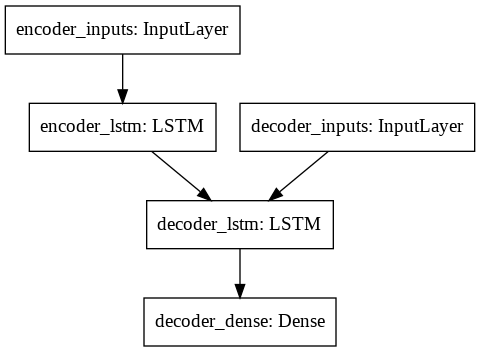

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')
from IPython.display import Image
Image(filename='model.png',height=400,width=400)

In [ ]:
checkpoint = ModelCheckpoint(filepath=WEIGHT_FILE_PATH, save_best_only=True)

## Training chatbot model

In [ ]:
model.fit(x=train_gen, steps_per_epoch=train_num_batches,
          epochs=NUM_EPOCHS,
          verbose=1, validation_data=test_gen, validation_steps=test_num_batches, callbacks=[checkpoint])

Epoch 1/5
951/951 [==============================] - 526s 553ms/step - loss: 1.5301 - accuracy: 0.0719 - val_loss: 1.4120 - val_accuracy: 0.0845
Epoch 2/5
951/951 [==============================] - 531s 559ms/step - loss: 1.3666 - accuracy: 0.0882 - val_loss: 1.3514 - val_accuracy: 0.0908
Epoch 3/5
951/951 [==============================] - 524s 551ms/step - loss: 1.3234 - accuracy: 0.0921 - val_loss: 1.3254 - val_accuracy: 0.0935
Epoch 4/5
951/951 [==============================] - 511s 538ms/step - loss: 1.2999 - accuracy: 0.0943 - val_loss: 1.3117 - val_accuracy: 0.0948
Epoch 5/5
951/951 [==============================] - 515s 542ms/step - loss: 1.2846 - accuracy: 0.0958 - val_loss: 1.3031 - val_accuracy: 0.0958


In [ ]:

model.save_weights(WEIGHT_FILE_PATH)

In [ ]:
model.save('partly_trained.h5')

##loading half trained model

In [ ]:
from keras import backend as K
from keras.models import load_model
loaded_model =  keras.models.load_model('partly_trained.h5')
print("Learning rate before first fit:", loaded_model.optimizer.learning_rate.numpy())

Learning rate before first fit: 0.01


In [ ]:
K.set_value(loaded_model.optimizer.learning_rate, 0.001)

In [ ]:
print("Learning rate after first fit:", loaded_model.optimizer.learning_rate.numpy())

Learning rate after first fit: 0.001


In [ ]:
%%time
history = loaded_model.fit(x=train_gen, steps_per_epoch=train_num_batches,
          epochs=10,
          verbose=1, validation_data=test_gen, validation_steps=test_num_batches, callbacks=[checkpoint])

Epoch 1/5
1260/1260 [==============================] - ETA: 0s - loss: 1.2318 - accuracy: 0.1043

In [ ]:
##the model was trained for 30 epocs with two learning rates, i.e 0.1 and 0.01

In [ ]:
loaded_model.save('trained_model.h5')

In [ ]:
#loaded_model.save_weights(WEIGHT_FILE_PATH)

In [ ]:
!pip install numpy==1.16.1
import numpy as np
#REF : https://stackoverflow.com/questions/55890813/how-to-fix-object-arrays-cannot-be-loaded-when-allow-pickle-false-for-imdb-loa

     |████████████████████████████████| 17.3MB 206kB/s 
ERROR: umap-learn 0.4.6 has requirement numpy>=1.17, but you'll have numpy 1.16.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5


##prediction

In [ ]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import nltk
import os
import sys
import zipfile
import urllib
from keras.models import model_from_json

HIDDEN_UNITS = 256
WHITELIST = 'abcdefghijklmnopqrstuvwxyz1234567890?.,'
GLOVE_EMBEDDING_SIZE = 100
DATA_SET_NAME = 'cornell'

class CornellWordGloveChatBot(object):
    model = None
    encoder_model = None
    decoder_model = None
    target_word2idx = None
    target_idx2word = None
    max_decoder_seq_length = None
    max_encoder_seq_length = None
    num_decoder_tokens = None
    word2em = None

    def __init__(self):
        self.word2em = word2embed
        #print(len(self.word2em))
        #print(self.word2em['start'])

        self.target_word2idx = np.load('word-glove-target-word2idx.npy').item()
        self.target_idx2word = np.load('word-glove-target-idx2word.npy').item()
        context = np.load('word-glove-context.npy').item()
        self.max_encoder_seq_length = context['encoder_max_seq_length']
        self.max_decoder_seq_length = context['decoder_max_seq_length']
        self.num_decoder_tokens = context['num_decoder_tokens']

        encoder_inputs = Input(shape=(None, GLOVE_EMBEDDING_SIZE), name='encoder_inputs')
        encoder_lstm = LSTM(units=HIDDEN_UNITS, return_state=True, name="encoder_lstm")
        encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)
        encoder_states = [encoder_state_h, encoder_state_c]

        decoder_inputs = Input(shape=(None, GLOVE_EMBEDDING_SIZE), name='decoder_inputs')
        decoder_lstm = LSTM(units=HIDDEN_UNITS, return_sequences=True, return_state=True, name='decoder_lstm')
        decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
        decoder_dense = Dense(self.num_decoder_tokens, activation='softmax', name='decoder_dense')
        decoder_outputs = decoder_dense(decoder_outputs)

        self.model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

        model_json = open('/content/word-architecture.json', 'r').read()
        self.model = model_from_json(model_json)
        self.model.load_weights('cornell-word-glove-weights.h5')
        self.model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

        self.encoder_model = Model(encoder_inputs, encoder_states)

        decoder_state_inputs = [Input(shape=(HIDDEN_UNITS,)), Input(shape=(HIDDEN_UNITS,))]
        decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_state_inputs)
        decoder_states = [state_h, state_c]
        decoder_outputs = decoder_dense(decoder_outputs)
        self.decoder_model = Model([decoder_inputs] + decoder_state_inputs, [decoder_outputs] + decoder_states)

    def reply(self, input_text):
        input_seq = []
        input_emb = []
        for word in nltk.word_tokenize(input_text.lower()):
            if not in_white_list(word):
                continue
            emb = np.zeros(shape=GLOVE_EMBEDDING_SIZE)
            if word in self.word2em:
                emb = self.word2em[word]
            input_emb.append(emb)
        input_seq.append(input_emb)
        input_seq = pad_sequences(input_seq, self.max_encoder_seq_length)
        states_value = self.encoder_model.predict(input_seq)
        target_seq = np.zeros((1, 1, GLOVE_EMBEDDING_SIZE))
        target_seq[0, 0, :] = self.word2em['start']
        target_text = ''
        target_text_len = 0
        terminated = False
        while not terminated:
            output_tokens, h, c = self.decoder_model.predict([target_seq] + states_value)
            [[0.43,1.32,0],[0,0,1]]
            sample_token_idx = np.argmax(output_tokens[0, -1, :])
            sample_word = self.target_idx2word[sample_token_idx]
            target_text_len += 1

            if sample_word != 'start' and sample_word != 'end':
                target_text += ' ' + sample_word

            if sample_word == 'end' or target_text_len >= self.max_decoder_seq_length:
                terminated = True

            target_seq = np.zeros((1, 1, GLOVE_EMBEDDING_SIZE))
            if sample_word in self.word2em:
                target_seq[0, 0, :] = self.word2em[sample_word]

            states_value = [h, c]
        return target_text.strip()

    def test_run(self):
        print(self.reply('good morning'))
        #print(self.reply('How are you doing?'))
        #print(self.reply('Have you heard the news?'))


def main():
    model = CornellWordGloveChatBot()
    model.test_run()

if __name__ == '__main__':
    main()

appearance appearance reagan species pipeline housekeeper foundation housekeeper foundation foundation housekeeper foundation fuck canceled excalibur excalibur starks treadstone machine section shades apiece touching problems verge touching cone sniffing sniffing bully exciting ammunition sniffing sniffing sniffing sniffing pet sniffing sniffing pet sniffing sniffing


With very less training model is able to predict this, clearly shows that training has to be for longer 

In [ ]:
##Further work can be done by to increase the accuracy and lower the loss by introducing the attention mechanism
#ref: https://towardsdatascience.com/intuitive-understanding-of-attention-mechanism-in-deep-learning-6c9482aecf4f